In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]), <a list of 10 Text xticklabel objects>)

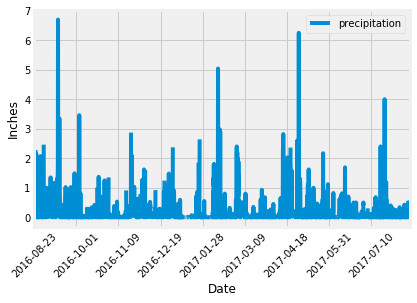

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
resultsdf = pd.DataFrame(results, columns = ['date', 'precipitation'])
resultsdf.set_index(resultsdf['date'], inplace = True)
resultsdf.index.name = None

# Sort the dataframe by date
resultsdf = resultsdf.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
resultsdf.plot()
plt.ylabel ("Inches")
plt.xlabel ("Date")
plt.legend(loc="upper right")
plt.xticks(rotation=45)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
resultsdf.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.station)).all()

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.round(func.avg(measurement.tobs), 2)).filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66)]

Text(0.5, 0, 'Temperature')

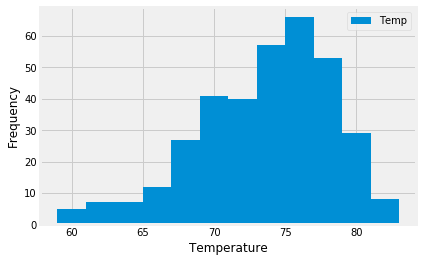

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temps = session.query(measurement.tobs).filter(measurement.date >= prev_year).filter(measurement.station == 'USC00519281').all()
stationdf = pd.DataFrame(station_temps, columns = ["Temp"])

stationdf.plot.hist(bins = 12)
plt.xlabel ("Temperature")

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2016, 8, 23)
prev_year_end = dt.date(2017, 8, 22)

tmin, tavg, tmax = calc_temps(prev_year_start, prev_year_end)[0]


58.0


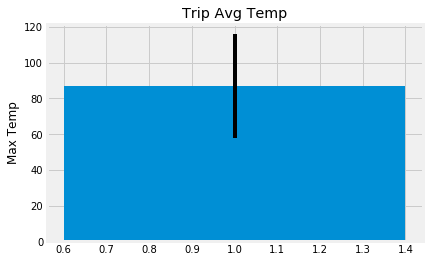

<Figure size 432x1800 with 0 Axes>

In [42]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmax - tmin

plt.bar(1, tmax, yerr = yerr)
plt.ylabel ("Max Temp")
plt.title ("Trip Avg Temp")
plt.figure(figsize=(6,25))
plt.tight_layout()

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(station.station, station.name, station.latitude, station.longitude, station.elevation,\
              func.sum(measurement.prcp)).filter(measurement.station == station.station).\
              filter(measurement.date >= prev_year_start).filter(measurement.date <= prev_year_end).group_by(station.name).\
              order_by(func.sum(measurement.prcp).desc()).all()


In [46]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
